<a href="https://colab.research.google.com/github/Mahdi-Golizadeh/DIFFUSION-DIFFUSER-LIB/blob/main/FineTuningDiffusionModel.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install -qq -U diffusers datasets

In [2]:
import torch
from datasets import load_dataset
from torchvision import transforms
from PIL import Image
import torchvision
import numpy as np
from diffusers import DDIMPipeline, DDIMScheduler
import matplotlib.pyplot as plt
from tqdm.auto import tqdm
from torch.amp import autocast, GradScaler
import torch.nn.functional as F

In [3]:
def show_images(x, NR=8):
    """Given a batch of images x, make a grid and convert to PIL"""
    x = x * 0.5 + 0.5  # Map from (-1, 1) back to (0, 1)
    grid = torchvision.utils.make_grid(x, nrow= NR)
    grid_im = grid.detach().cpu().permute(1, 2, 0).clip(0, 1) * 255
    grid_im = Image.fromarray(np.array(grid_im).astype(np.uint8))
    return grid_im


def make_grid(images, size=64):
    """Given a list of PIL images, stack them together into a line for easy viewing"""
    output_im = Image.new("RGB", (size * len(images), size))
    for i, im in enumerate(images):
        output_im.paste(im.resize((size, size)), (i * size, 0))
    return output_im

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(device)

cuda


In [5]:
!gdown 1BLjDxyZBGPkJ_xqCvh2hhp6P0elhY2Fm

Downloading...
From (original): https://drive.google.com/uc?id=1BLjDxyZBGPkJ_xqCvh2hhp6P0elhY2Fm
From (redirected): https://drive.google.com/uc?id=1BLjDxyZBGPkJ_xqCvh2hhp6P0elhY2Fm&confirm=t&uuid=31692208-b196-4fa3-b206-0da51ad927c2
To: /content/data.zip
100% 231M/231M [00:01<00:00, 196MB/s]


In [6]:
!unzip -o -q data.zip -d /content/anime_dataset

In [7]:
# Or load images from a local folder
dataset = load_dataset("imagefolder", data_dir="/content/anime_dataset/data", split= "train[:10%]")

# We'll train on 32-pixel square images, but you can try larger sizes too
image_size = 256
# You can lower your batch size if you're running out of GPU memory
batch_size = 4

# Define data augmentations
preprocess = transforms.Compose(
    [
        transforms.Resize((image_size, image_size)),  # Resize
        transforms.ToTensor(),  # Convert to tensor (0, 1)
        transforms.Normalize([0.5], [0.5]),  # Map to (-1, 1)
    ]
)


def transform(examples):
    images = [preprocess(image.convert("RGB")) for image in examples["image"]]
    return {"images": images}


dataset.set_transform(transform)

# Create a dataloader from the dataset to serve up the transformed images in batches
train_dataloader = torch.utils.data.DataLoader(
    dataset, batch_size=batch_size, shuffle=True
)

Resolving data files:   0%|          | 0/21551 [00:00<?, ?it/s]

X shape: torch.Size([4, 3, 256, 256])


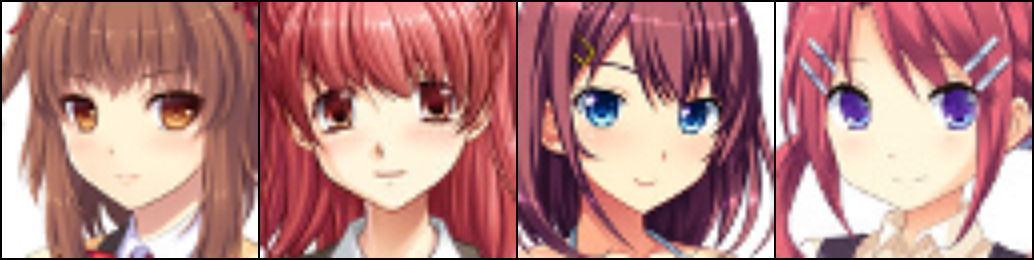

In [8]:
xb = next(iter(train_dataloader))["images"].to(device)[:4]
print("X shape:", xb.shape)
show_images(xb)

In [9]:
image_pipe = DDIMPipeline.from_pretrained("google/ddpm-celebahq-256", use_safetensors=False)
image_pipe.to(device);

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


Loading pipeline components...:   0%|          | 0/2 [00:00<?, ?it/s]

In [10]:
image = image_pipe().images[0]

  0%|          | 0/50 [00:00<?, ?it/s]

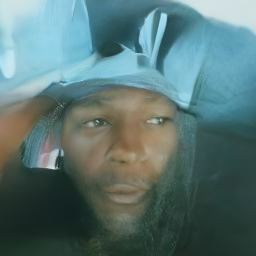

In [11]:
image

In [12]:
# Create new scheduler and set num inference steps
scheduler = DDIMScheduler.from_pretrained("google/ddpm-celebahq-256")
scheduler.set_timesteps(num_inference_steps=40)

0it [00:00, ?it/s]

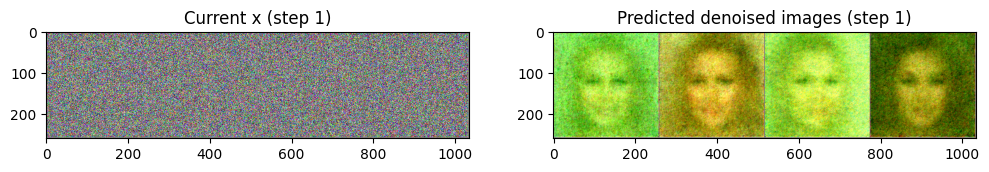

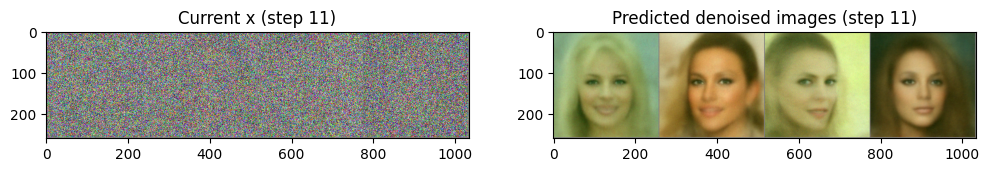

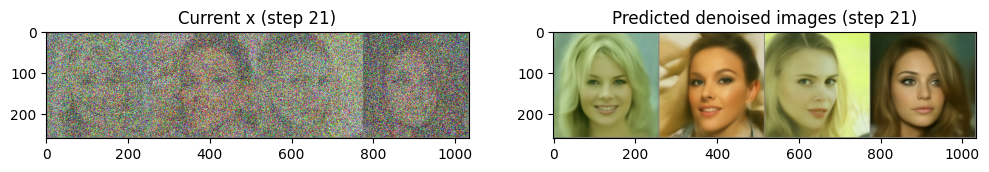

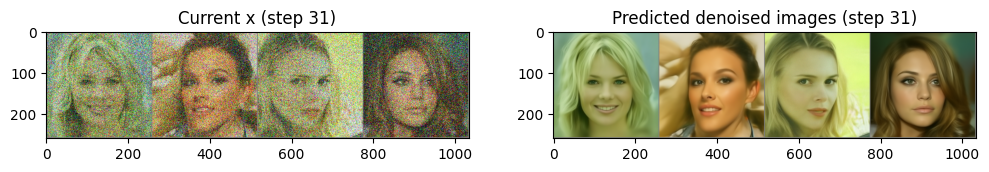

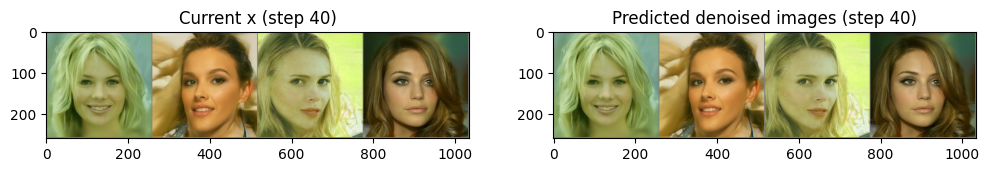

In [13]:
# The random starting point
x = torch.randn(4, 3, 256, 256).to(device)  # Batch of 4, 3-channel 256 x 256 px images

# Loop through the sampling timesteps
for i, t in tqdm(enumerate(scheduler.timesteps)):

    # # Prepare model input
    model_input = scheduler.scale_model_input(x, t)

    # # Get the prediction
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]

    # # Calculate what the updated sample should look like with the scheduler
    scheduler_output = scheduler.step(noise_pred, t, x)

    # # Update x
    x = scheduler_output.prev_sample

    # Occasionally display both x and the predicted denoised images
    if i % 10 == 0 or i == len(scheduler.timesteps) - 1:
        fig, axs = plt.subplots(1, 2, figsize=(12, 5))

        grid = torchvision.utils.make_grid(x, nrow=4).permute(1, 2, 0)
        axs[0].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[0].set_title(f"Current x (step {i+1})")

        pred_x0 = (
            scheduler_output.pred_original_sample
        )  # Not available for all schedulers
        grid = torchvision.utils.make_grid(pred_x0, nrow=4).permute(1, 2, 0)
        axs[1].imshow(grid.cpu().clip(-1, 1) * 0.5 + 0.5)
        axs[1].set_title(f"Predicted denoised images (step {i+1})")
        plt.show()

In [14]:
# Training loop
optimizer = torch.optim.AdamW(image_pipe.unet.parameters(), lr=1e-5)

# Initialize GradScaler for mixed precision training
scaler = GradScaler(device="cuda")  # Specify device_type as "cuda"

losses = []
EPOCHS = 5
for epoch in range(EPOCHS):
    # Wrap the train_dataloader with tqdm for a progress bar
    progress_bar = tqdm(train_dataloader, desc=f"Epoch {epoch + 1}/{EPOCHS}", leave=True)
    epoch_loss=0
    for step, batch in enumerate(progress_bar):
        clean_images = batch["images"].to(device)
        # Sample noise to add to the images
        noise = torch.randn(clean_images.shape).to(clean_images.device)
        bs = clean_images.shape[0]

        # Sample a random timestep for each image
        timesteps = torch.randint(
            0, scheduler.config.num_train_timesteps, (bs,), device=clean_images.device
        ).long()

        # Add noise to the clean images according to the noise magnitude at each timestep
        noisy_images = scheduler.add_noise(clean_images, noise, timesteps)

        # Zero the gradients
        optimizer.zero_grad()

        # Forward pass with autocast for mixed precision
        with autocast(device_type="cuda"):  # Specify device_type as "cuda"
            # Get the model prediction
            noise_pred = image_pipe.unet(noisy_images, timesteps, return_dict=False)[0]

            # Calculate the loss
            loss = F.mse_loss(noise_pred, noise)

        # Backward pass with GradScaler
        scaler.scale(loss).backward()

        # Update the model parameters with the optimizer
        scaler.step(optimizer)

        # Update the GradScaler for the next iteration
        scaler.update()
        epoch_loss+= loss.item()
        # Record the loss


        # Update the progress bar description with the current loss
        progress_bar.set_postfix(loss=epoch_loss)
    losses.append(epoch_loss)

Epoch 1/5:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/539 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/539 [00:00<?, ?it/s]

0it [00:00, ?it/s]

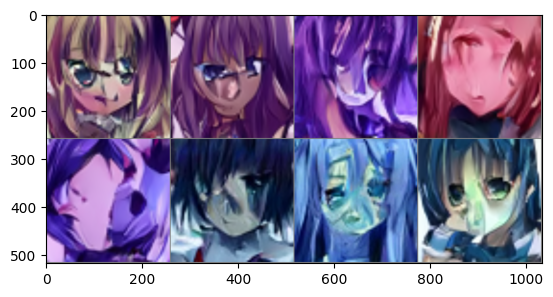

In [15]:
x = torch.randn(8, 3, 256, 256).to(device)  # Batch of 8
for i, t in tqdm(enumerate(scheduler.timesteps)):
    model_input = scheduler.scale_model_input(x, t)
    with torch.no_grad():
        noise_pred = image_pipe.unet(model_input, t)["sample"]
    x = scheduler.step(noise_pred, t, x).prev_sample
grid = torchvision.utils.make_grid(x, nrow=4)
plt.imshow(grid.permute(1, 2, 0).cpu().clip(-1, 1) * 0.5 + 0.5);